## Exercise 1

Find an optimal learning rate for the handwriting MNIST data.  After this, verify that your learning rate achieves better performance than values that are either larger or smaller.

In [1]:
#%pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 3.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 44.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 42.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.1 MB/s eta 0:00:00:00:0

In [2]:
import tensorflow as tf
from keras.datasets import mnist

mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
import math
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        self.model.optimizer.learning_rate = self.model.optimizer.learning_rate * self.factor

In [23]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    model.optimizer.learning_rate = min_rate
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    model.optimizer.learning_rate = init_lr
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [24]:
import matplotlib.pyplot as plt

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

2024-04-09 14:48:10.937605: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1907 - loss: 2.1449


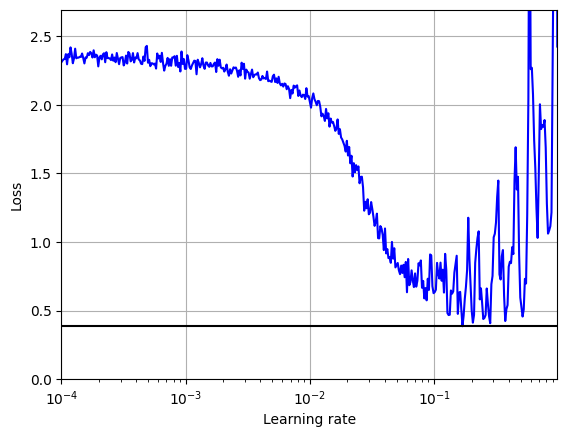

In [25]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [26]:
optimal_lr = 0.1
optimizer = tf.keras.optimizers.SGD(learning_rate=optimal_lr)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,metrics=["accuracy"])
history_optimal_lr = model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

Epoch 1/10


2024-04-09 14:52:11.082025: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8497 - loss: 0.4761 - val_accuracy: 0.9666 - val_loss: 0.1064
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9606 - loss: 0.1298 - val_accuracy: 0.9746 - val_loss: 0.0816
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9730 - loss: 0.0878 - val_accuracy: 0.9788 - val_loss: 0.0790
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9809 - loss: 0.0650 - val_accuracy: 0.9750 - val_loss: 0.0910
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9843 - loss: 0.0515 - val_accuracy: 0.9742 - val_loss: 0.0930
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9881 - loss: 0.0396 - val_accuracy: 0.9784 - val_loss: 0.0855
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9903 - loss: 0.0326 - val_accuracy: 0.9770 - val_loss: 0.0829
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9910 - loss: 0.0283 - val_accurac

## Exercise 2

Compare a one cycle learning rate schedule to a power law schedule for the handwriting data.  Which can you make perform more effectively?

In [33]:
## make data noisy first
import numpy as np

mnist = tf.keras.datasets.mnist.load_data()

(train_images, train_labels), (test_images, test_labels) = mnist

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add noise
noise_factor = 0.5
train_images_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape) 
test_images_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)

train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)

#redefine build_and_train_model bc of new data
def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(train_images_noisy, train_labels, epochs=10,
                     validation_data=(test_images_noisy, test_labels))

In [36]:
## POWER LAW

class PowerScheduling(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_rate, step_param):
        super(PowerScheduling, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_rate = decay_rate
        self.step_param = step_param

    def __call__(self, step):
        # Note the "cast" here - necessary to make sure we get the correct type back
        return self.initial_learning_rate / (1 + tf.cast(step, tf.float32) / self.step_param) ** self.decay_rate


# Example usage
initial_learning_rate = 0.1
decay_rate = 1.0  # For linear decay
step_param = 1000.0  # Determines how quickly the learning rate decreases

lr_schedule = PowerScheduling(initial_learning_rate, decay_rate, step_param)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6969 - loss: 0.8906 - val_accuracy: 0.8767 - val_loss: 0.3838
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8936 - loss: 0.3315 - val_accuracy: 0.8883 - val_loss: 0.3360
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9184 - loss: 0.2594 - val_accuracy: 0.8965 - val_loss: 0.3152
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9310 - loss: 0.2222 - val_accuracy: 0.9008 - val_loss: 0.3044
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9394 - loss: 0.1978 - val_accuracy: 0.9027 - val_loss: 0.2992
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9449 - loss: 0.1802 - val_accuracy: 0.9049 - val_loss: 0.2955
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9498 - loss: 0.1665 - val_accuracy: 0.9057 - val_loss: 0.2936
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9537 - loss: 0.1555 - 

In [40]:
## ONE CYCLE
batch_size = 32

class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None, cutover=0.5):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.cutover = cutover
        self.half_iteration = int((iterations - self.last_iterations) * cutover)
        self.second_phase_start = self.half_iteration + ((iterations - self.last_iterations) - self.half_iteration) * cutover
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs=None):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr, self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr


model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 10
onecycle = OneCycleScheduler(math.ceil(len(train_images_noisy) / batch_size) * n_epochs,
                             max_lr=0.1,cutover=0.5)
history = model.fit(train_images_noisy, train_labels, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(test_images_noisy, test_labels),
                    callbacks=[onecycle])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5459 - loss: 1.3319 - val_accuracy: 0.7933 - val_loss: 0.6107
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8394 - loss: 0.4991 - val_accuracy: 0.8629 - val_loss: 0.4162
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8801 - loss: 0.3697 - val_accuracy: 0.8874 - val_loss: 0.3463
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9066 - loss: 0.2909 - val_accuracy: 0.8970 - val_loss: 0.3185
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9214 - loss: 0.2384 - val_accuracy: 0.9059 - val_loss: 0.3094
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9456 - loss: 0.1683 - val_accuracy: 0.9069 - val_loss: 0.3247
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9684 - loss: 0.1017 - val_accuracy: 0.9140 - val_loss: 0.3260
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9842 - loss: 0.0594 - 

## Exercise 3

Re-run all of the code in the second notebook with the handwriting data, instead of the fashion data; graph your losses (training and validation).  Do you achieve similar results?

## Exercise 4

Sometimes, adaptive optimizers fail, and non-adaptive optimizers like NAG or SGD perform a lot better.  This is sometimes the case with noisy data.

In the following, I've create a simple framework to examine the behavior of different optimizers with different noise levels.  Try running with an adaptive optimizer (AdamW) and a non-adaptive optimizer (NAG / SGD) with different levels of noise.  Do you find a point with NAG starts to outperform AdamW?  What happens if you adjust learning rates?

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add noise
noise_factor = 0.5
train_images_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape) 
test_images_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)

train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)

# Define a simple neural network model
def create_model(optimizer):
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model